# NPZD state estimation using a stochastic EnKF – Matlab version

 * This is an example of 4-dimensional, variational state estimation using a stochastic Ensemble Kalman filter (SEnKF).
 * The ocean biological model used in this example is a simple 0-dimensional (single box) NPZD model with 6 parameters, of which any subset can be estimated.
 * To change the parameter estimation setup, the observations, or the SEnKF configuration, modify the settings in the **settings changeable by the user** cell below.
 * This model is using the same model and data assimilation techniques as the [EnKF parameter estimation notebook](parameter_estimation_enkf.ipynb).

### preparation

In [1]:
% colorblind-friendly colors for N, P, Z, D
colors = {[68, 119, 170]./255, [34, 136, 51]./255, [238, 102, 119]./255, [204, 187, 68]./255};


ans =

    '9.7.0.1296695 (R2019b) Update 4'



### settings changeable by the user

Below are the main settings that determine the parameter estimation configuration.

rng(seed): Set an integer seed value for the pseudo-random number generator. Comment out this line to not set a seed and obtain different results every time the notebook is run.

t: Time vector determining the length and time-stepping for each model simulation. It is recommended to start t at 0 and use a time stepping of 1 day.

obs_info: Contains one or multiple entries that determine the observations used in the parameter estimation. Each entry corresponds to an observation and needs to contain 3 values:

    A time index for t (integer), setting the time when the observation was taken.
    The observed variable ('N', 'P', 'Z', or 'D').
    The uncertainty of the observation.

The observations are then generated from the "truth" by indexing it at the specified time index for the specified variable and adding normal pseudo-random noise with a zero mean and standard deviation based on the specified uncertainty. To not add noise to the observations, see perfect_observations below.

perfect_observations: If set to false (default), the observation uncertainty in obs_info is used to add noise to the observations. If set to true, no noise is added, and the "true" state is observed perfectly. Note that the observation uncertainty is always used in the computation of the cost and fitness function.

x0_true: Specifies the "true" initial conditions.

x0_prior: Specifies the prior (mean) estimate of the initial conditions.

x0_uncertainty: Specifies the uncertainty in the prior initial conditions. It acts as the standard deviation of pseudo-random normal, zero-mean noise that is added to x0_prior to create the forecast ensemble.

nens: The number of ensemble members used in the SEnKF.

show_cost: If set to true, compute and display gridded cost function values in one of the plots. This can take a long time, and can be turned off by setting show_cost to false.


In [2]:
% set seed of pseudo-random number generator for reproducible results
rng(20220412);

% initialize time vector (default: 2 years)
t = 0:1:2*365-1;

% select when to observe state in time, which variable, and with which uncertainty
obs_info = { ...
% each entry contains
% {time (index for t, integer), variable ('N', 'P', 'Z', or 'D'),  observation uncertainty}
    {100, 'N', 0.01}, ...
    {200, 'N', 0.01}, ...
    {150, 'P', 0.02}, ...
    {200, 'P', 0.02}, ...
    {250, 'P', 0.02}, ...
    {300, 'P', 0.02}, ...
    {350, 'P', 0.02}, ...
    {400, 'P', 0.02} ...
};

perfect_observations = false;

% true initial conditions
x0_true = [0.6, 0.15, 0.2, 0.05];

% prior estimate of initial conditions
x0_prior = [0.4, 0.05, 0.5, 0.1];

% initial conditions
x0_uncertainty = [0.05, 0.05, 0.05, 0.05];

% number of ensemble members
nens = 40;

% show cost function grid
show_cost = true;

### model code

The cell below contains the model parameters and the NPZD model code, for use with a ordinary differential equation integrator, such as `ode45`. Note that the parameter values in `parameters` act as constant reference values.

In [3]:
% parameter values
parameters = struct(...
    'vmax', 0.075, ...       % maximum growth rate in Michaelis Menten formulation
    'nuthalfsat', 0.3, ...   % nutrient half saturation in Michaelis Menten formulation
    'graz', 0.02, ...        % zooplankton grazing rate
    'mortP', 0.02, ...       % phytoplankton mortality rate
    'mortZ', 0.03, ...       % zooplankton mortality rate
    'reminrate', 0.1 ...     % remineralization rate
);

In [4]:
%%file npzd.m
% the above line is required to create a matlab function inside a Jupyter notebook cell
function out = npzd(x, t, parameters, npzd_light)
    %{
    input
    =====
    x: model state
    t: current time (in days)
    parameters: model parameters
    light: light function returning irradiance at time t
    %}
    n = max(x(1), 0.0);
    p = max(x(2), 0.0);
    z = max(x(3), 0.0);
    d = max(x(4), 0.0);

    growth = parameters.('vmax') * n / (parameters.('nuthalfsat') + n) * npzd_light(t) * p;
    grazing = parameters.('graz') * p * z;
    p_loss = parameters.('mortP') * p;
    z_loss = parameters.('mortZ') * z * z;
    remin = parameters.('reminrate') * d;

    out = [-growth+remin, growth-grazing-p_loss, grazing-z_loss, p_loss+z_loss-remin];
end

Created file '/home/jmattern/projects/20220211_matlab_kernel/obm-primer/npzd.m'.


### code to run model

Helper functions for computing the light at time t (in units of days), which is a simple sinusoidal function, and running the NPZD model forward.
The time vector `t` determines the length of each NPZD model simulation.

In [5]:
%%file npzd_light.m
% light function returning irradiance at time t
function out = npzd_light(t)
    out =  1.0 + 0.5 * (0.8 * sin(pi * ((t - 81.25) / 182.5)) - 0.8);
end

Created file '/home/jmattern/projects/20220211_matlab_kernel/obm-primer/npzd_light.m'.


In [6]:
npzd_ode = @(t, x) npzd(x, t, parameters, @npzd_light)';

In [7]:
%%file observation_operator.m
function out = observation_operator(trajectory, obs_info)
    out = nan(1, length(obs_info));
    for iobs = 1:length(obs_info)
        out(iobs) = trajectory(obs_info{iobs}{1}, strfind('NPZD', obs_info{iobs}{2}));
    end
end

Created file '/home/jmattern/projects/20220211_matlab_kernel/obm-primer/observation_operator.m'.


### generate synthetic data from "true" initial conditions (`x0_true`)

In [8]:
% number of observations
nobs = length(obs_info);
nx0 = length(x0_prior);

% use model to generate the synthetic data
% true_state is the true model state without any added noise
[t_ode, trajectory] = ode45(npzd_ode, t, x0_true);
obs_true = observation_operator(trajectory, obs_info);

% extract observation uncertainty
obs_uncertainty = nan(1, nobs);
for iobs = 1:nobs
    obs_uncertainty(iobs) = obs_info{iobs}{3};
end

% generate observations
if perfect_observations
    obs = obs_true;
else
    obs = obs_true + obs_uncertainty .* randn(1, nobs);
end

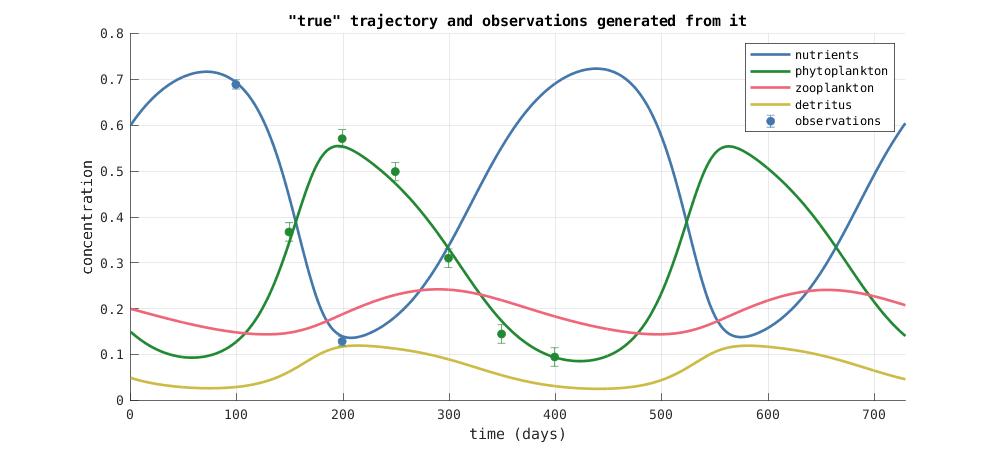

In [9]:
%plot -w 1000 -h 450
[t_ode, trajectory] = ode45(npzd_ode, t, x0_true);

figure

hold on
grid on

for ivar = 1:4
    plot(t_ode, trajectory(:,ivar), 'color', colors{ivar}, 'linewidth', 2)
end

for iobs = 1:nobs
    it = obs_info{iobs}{1};
    ivar = strfind('NPZD', obs_info{iobs}{2});

    errorbar(t(it), obs(iobs), obs_uncertainty(iobs), 'o', 'color', colors{ivar}, ...
             'markerfacecolor', colors{ivar})
end

legend({'nutrients', 'phytoplankton', 'zooplankton', 'detritus', 'observations'})

xlabel('time (days)')
ylabel('concentration')
title('"true" trajectory and observations generated from it')
xlim([t(1), t(end)])

### create and plot ensembles

In [10]:
% generate ensemble of observations adding pseudo-random noise to obs_true
Y = obs' + obs_uncertainty' .* randn([nobs, nens]);

% generate the prior ensemble of parameters X by adding pseudo-random noise to the parameters
X_mean = x0_prior;

X = max(0.0, X_mean' + x0_uncertainty' .* randn([nx0, nens]));

% for each initial condition in X, run the NPZD model to generate HX, the prior ensemble of model states
% at the observations
HX = zeros([nobs, nens]);
for iens = 1:nens
    [t_ode, trajectory] = ode45(npzd_ode, t, X(:, iens));
    HX(:, iens) = observation_operator(trajectory, obs_info);
end

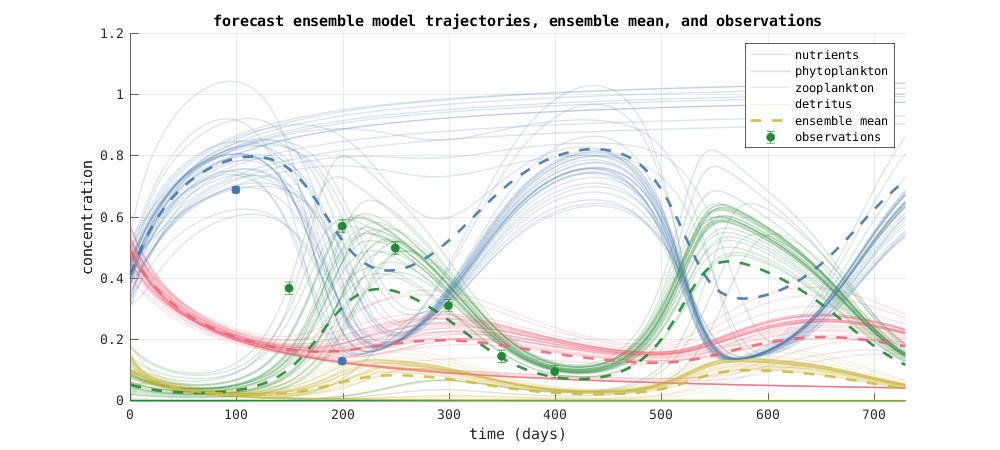

In [11]:
%plot -w 1000 -h 450
figure

hold on
grid on

plot_mean = true;
plot_observation_ensemble = false;

% upper limit on number of trajectories to include in plot
max_plot = 50;
handles = zeros(1, 6);

for iens = 1:nens
    [t_ode, trajectory] = ode45(npzd_ode, t, X(:, iens));
    if iens == 1
        trajectory_sum = trajectory;
    else
        trajectory_sum = trajectory_sum + trajectory;
    end
    if iens <= max_plot
        for ivar = 1:4
            handles(ivar) = plot(t_ode, trajectory(:,ivar), 'color', [colors{ivar}, 0.2], 'linewidth', 1);
        end
    end
end

if plot_mean
    for ivar = 1:4
        handles(5) = plot(t_ode, trajectory_sum(:,ivar)./nens, '--', 'color', [colors{ivar}, 0.9], ...
                          'linewidth', 2);
    end
end

for iobs = 1:nobs
    it = obs_info{iobs}{1};
    ivar = strfind('NPZD', obs_info{iobs}{2});

    handles(6) = errorbar(t(it), obs(iobs), obs_uncertainty(iobs), 'o', 'color', colors{ivar}, ...
                          'markerfacecolor', colors{ivar});
end

legend(handles, {'nutrients', 'phytoplankton', 'zooplankton', 'detritus', 'ensemble mean', 'observations'})

xlabel('time (days)')
ylabel('concentration')
title('forecast ensemble model trajectories, ensemble mean, and observations')
xlim([t(1), t(end)])

### code to perform data assimilation

Run the Ensemble Kalman Filter. Below, the symbols denote:

`HBHT`: $\mathbf{H}\mathbf{B}\mathbf{H}^T$

`BHT`: $\mathbf{B}\mathbf{H}^T$

`R`: $\mathbf{R}$

`K`: $\mathbf{B}\mathbf{H}^T \left(\mathbf{H}\mathbf{B}\mathbf{H}^T + \mathbf{R}\right)^{-1}$ (Kalman gain)

In [12]:
HBHT = cov(HX');
BHT = (X-mean(X,2)) * (HX-mean(HX,2))' / (nens - 1);
R = diag(obs_uncertainty.^2);

K = BHT * inv(HBHT + R);

% use kalman gain to compute update for each ensemble member in X, and store updated ensemble in X_post
X_post = zeros(size(X));
for iens = 1:nens
    X_post(:, iens) = X(:, iens) + K * (Y(:,iens) - HX(:,iens));
end
% enforce a minimum value of zero
X_post = max(X_post, 0);

### plot analysis ensemble

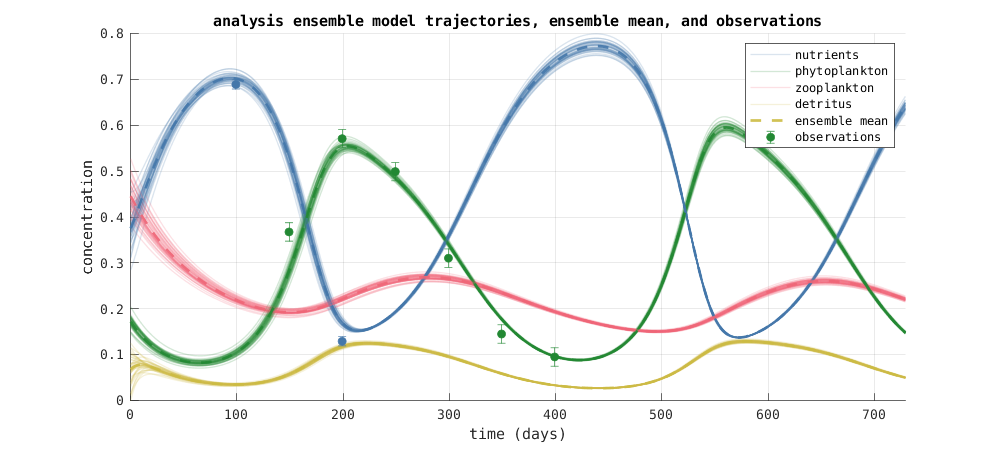

In [13]:
%plot -w 1000 -h 450
figure

hold on
grid on

plot_mean = true;
plot_observation_ensemble = false;

% upper limit on number of trajectories to include in plot
max_plot = 50;
handles = zeros(1, 6);

for iens = 1:nens
    [t_ode, trajectory] = ode45(npzd_ode, t, X_post(:, iens));
    if iens == 1
        trajectory_sum = trajectory;
    else
        trajectory_sum = trajectory_sum + trajectory;
    end
    if iens <= max_plot
        for ivar = 1:4
            handles(ivar) = plot(t_ode, trajectory(:,ivar), 'color', [colors{ivar}, 0.2], 'linewidth', 1);
        end
    end
end

if plot_mean
    for ivar = 1:4
        handles(5) = plot(t_ode, trajectory_sum(:,ivar)./nens, '--', 'color', [colors{ivar}, 0.9], ...
                          'linewidth', 2);
    end
end

for iobs = 1:nobs
    it = obs_info{iobs}{1};
    ivar = strfind('NPZD', obs_info{iobs}{2});

    handles(6) = errorbar(t(it), obs(iobs), obs_uncertainty(iobs), 'o', 'color', colors{ivar}, ...
                          'markerfacecolor', colors{ivar});
end

legend(handles, {'nutrients', 'phytoplankton', 'zooplankton', 'detritus', 'ensemble mean', 'observations'})

xlabel('time (days)')
ylabel('concentration')
title('analysis ensemble model trajectories, ensemble mean, and observations')
xlim([t(1), t(end)])

### compute gridded cost function (if desired)

**Note:** If this step takes too much time, set `show_cost` to `false`.

In [14]:
% when determining the grid on which to compute cost function, include the forecast ensemble
include_prior = true;

% include J_b
include_j_b = true;

B_inv = diag(1./x0_uncertainty.^2);

variables = 'NPZD';

if show_cost
    res = 20;
    cost_slices = struct();
    cost_grid = {[], [], [], []};
    for ivar0 = 1:4
        for ivar1 = 1:4
            if ivar0 >= ivar1
                continue
            end
            key = strcat(variables(ivar0), variables(ivar1));
            if isfield(cost_slices, key)
                continue
            end

            for ivar = [ivar0, ivar1]
                if length(cost_grid{ivar}) == 0
                    v_min = min(min(X_post(ivar, :)), x0_true(ivar));
                    v_max = max(max(X_post(ivar, :)), x0_true(ivar));
                    if include_prior
                        v_min = min(v_min, min(X(ivar, :)));
                        v_max = max(v_max, max(X(ivar, :)));
                    end
                    % add additional entry, taken off by pcolor
                    cost_grid{ivar} = [linspace(v_min, v_max, res), v_max];
                end
            end
            % add additional entry, taken off by pcolor
            cost_slices.(key) = nan(res+1, res+1);
            for i0 = 1:res
                for i1 = 1:res
                    x0 = x0_true;
                    x0(ivar0) = cost_grid{ivar0}(i0);
                    x0(ivar1) = cost_grid{ivar1}(i1);

                    [t_ode, trajectory] = ode45(npzd_ode, t, x0);
                    j_o = sum(((obs-observation_operator(trajectory, obs_info)) ./ obs_uncertainty).^2);
                    if include_j_b
                        tmp = x0_prior - x0;
                        j_b = tmp * B_inv * tmp';
                        cost_slices.(key)(i0, i1) = 0.5 * (j_o + j_b);
                    else
                        cost_slices.(key)(i0, i1) = j_o;
                    end
                end
            end
        end
    end
end

In [15]:
%%file draw_ensemble.m
function h = draw_ensemble(ensemble, color, marker)

    ensmean = mean(ensemble, 2);
    enscov = cov(ensemble');

    a = enscov(1, 1);
    b = enscov(2, 1);
    c = enscov(2, 2);

    tmp = sqrt((0.5 * (a - c))^2 + b^2);
    l1 = 0.5 * (a + c) + tmp;
    l2 = 0.5 * (a + c) - tmp;

    if b == 0 and a >= c
        angle = 0;
    elseif b == 0 and a < c
        angle = pi / 2;
    else
        angle = atan2(l1 - a, b);
    end

    sinbeta = sin(angle);
    cosbeta = cos(angle);

    alpha = linspace(0, 2*pi, 200)';
    sinalpha = sin(alpha);
    cosalpha = cos(alpha);

    l1 = sqrt(l1);
    l2 = sqrt(l2);

    x = ensmean(1) + (l1 * cosalpha * cosbeta - l2 * sinalpha * sinbeta);
    y = ensmean(2) + (l1 * cosalpha * sinbeta + l2 * sinalpha * cosbeta);

    fill(x, y, color, 'EdgeColor', color, 'FaceAlpha', 0.3);
    h = plot(ensemble(1, :), ensemble(2, :), 'Marker', marker, 'Color', color, 'MarkerFaceColor', color, ...
         'LineStyle', 'none', 'MarkerSize', 4);
    plot(ensmean(1), ensmean(2), 'Marker', marker, 'Color', color, 'MarkerFaceColor', color, ...
        'LineStyle', 'none', 'MarkerSize', 15)
end

Created file '/home/jmattern/projects/20220211_matlab_kernel/obm-primer/draw_ensemble.m'.


### plot the ensemble

Plot the ensemble and associated normal distribution (mean and covariance ellipse) before and after assimilation.

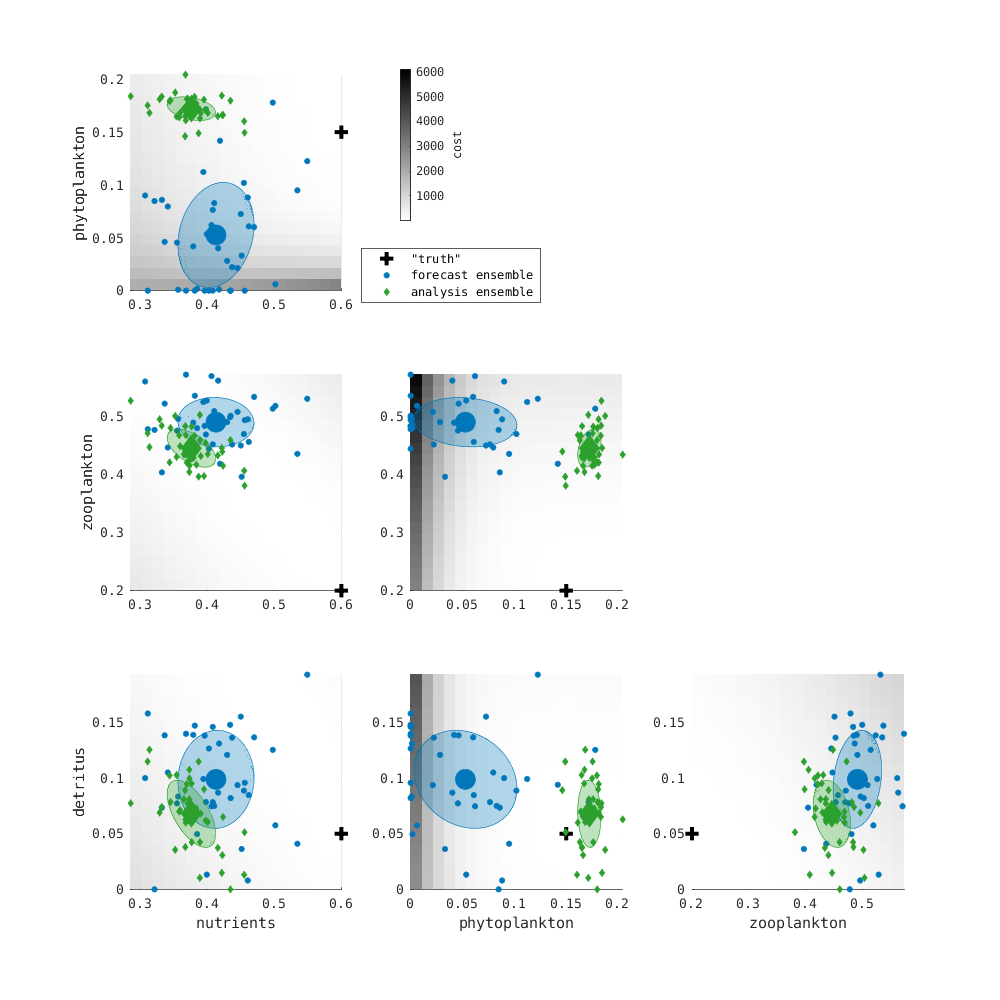

In [16]:
%plot -w 1000 -h 1000

figure

colormap(flipud(gray));
nrows = nx0 - 1;
ncols = nx0 - 1;

state_names = {'nutrients', 'phytoplankton', 'zooplankton', 'detritus'};

vmin = 100000;
vmax = 0;

for icol = 1:ncols
    for irow = 1:nrows
        subplot(nrows, ncols, (irow-1) * nrows + icol)

        if irow < icol
            set(gca(), 'Visible', 'off')
            continue
        end

        ix = icol;
        iy = irow + 1;

        hold on
        grid on

        hlegend = nan(1, 3);

        if show_cost
            key = strcat(variables(ix), variables(iy));
            if isfield(cost_slices, key)
                h = pcolor(cost_grid{ix}, cost_grid{iy}, cost_slices.(key)');
            else
                key = strcat(variables(iy), variables(ix));
                h = pcolor(cost_grid{iy}, cost_grid{ix}, cost_slices.(key));
            end
            set(h, 'EdgeColor', 'none');
            vminmax = caxis;
            vmin = min(vmin, vminmax(1));
            vmax = max(vmax, vminmax(2));
        end

        if irow == nrows
            xlabel(state_names{ix})
        end
        if icol == 1
            ylabel(state_names{iy})
        end
        hlegend(1) = plot(x0_true(ix), x0_true(iy), 'LineStyle', 'none', 'Marker', '+', ...
                          'MarkerEdgeColor', 'k', 'MarkerSize', 10, 'LineWidth', 3);
        hlegend(2) = draw_ensemble(X([ix, iy], :), [0, 119, 187]/255, 'o');
        hlegend(3) = draw_ensemble(X_post([ix, iy], :), [44, 160, 44]/255, 'd');

        if show_cost
            xlim([cost_grid{ix}(1), cost_grid{ix}(end)])
            ylim([cost_grid{iy}(1), cost_grid{iy}(end)])

            if irow == 1 && icol == 1
                cb = colorbar('Position', [.4 .78 .01 .15]);
                cb.Label.String = 'cost';
            end
        end
        if irow == 1 && icol == 1
            legend(hlegend, {'"truth"', 'forecast ensemble', 'analysis ensemble'}, 'Position', [.4 .7 .1 .05])
        end
    end
end


if show_cost
    % equalize color scale for background cost function across panels
    for icol = 1:ncols
        for irow = 1:nrows
            subplot(nrows, ncols, (irow-1) * nrows + icol)

            if irow < icol
                continue
            end
            caxis([vmin, vmax])
        end
    end
end